In [1]:
%matplotlib inline
from __future__ import print_function
import cv2
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import sys
import os
import time
from itertools import product

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

----

## Image Convolution

In [3]:
def gaussian_kernel(size, sigma):
    height, width = size
    if height % 2 == 0:
        height += 1
    if width % 2 == 0:
        width += 1
    new_size = (height, width)
    kernel = np.zeros(new_size)
    kernel[int(height/2), int(width/2)] = 1
    
    return cv2.GaussianBlur(kernel, new_size, sigma)

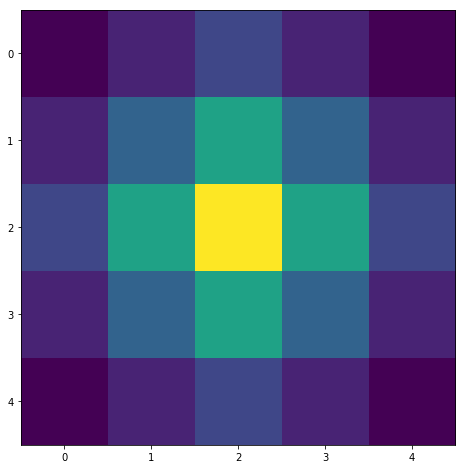

In [4]:
plt.imshow(gaussian_kernel((5,5),1), interpolation='none')

In [5]:
def cv_gaussian_kernel(size, sigma):
    if size % 2 == 0:
        size += 1
    kernel_1D = cv2.getGaussianKernel(size, sigma)
    return kernel_1D.dot(kernel_1D.T)

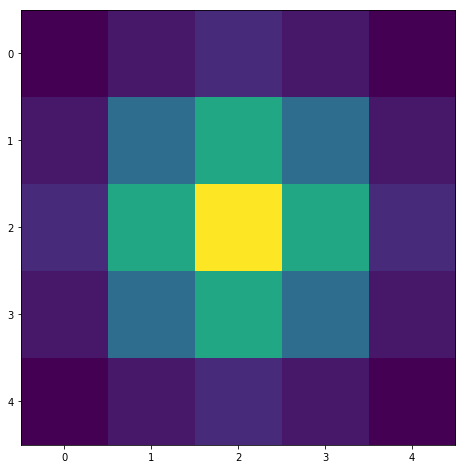

In [6]:
plt.imshow(cv_gaussian_kernel(5, 1), interpolation='none')

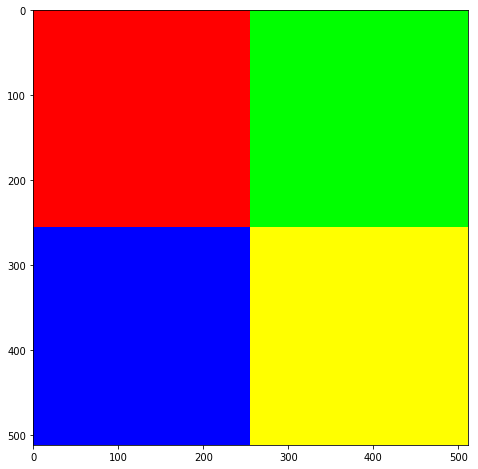

In [7]:
# image window
test_image = np.zeros((512, 512, 3), dtype=np.uint8)
test_image[:256,:256,0] = 255
test_image[:256,256:,1] = 255
test_image[256:,:256,2] = 255
test_image[256:,256:,0] = 255
test_image[256:,256:,1] = 255

plt.imshow(test_image)

In [8]:
def get_image_window(image, center, win_width, pad_value=0):
    image_height, image_width = image.shape[:2]
    if len(image.shape) > 2:
        pad_image_size = (image_height+win_width, image_width+win_width, 3)
        win_size = (win_width, win_width, 3)
    else:
        pad_image_size = (image_height+win_width, image_width+win_width)
        win_size = (win_width, win_width)
    padded_image = np.zeros(pad_image_size, dtype=np.uint8)
    half_win_width = int(win_width/2)
    padded_image[half_win_width:half_win_width+image_height, half_win_width:half_win_width+image_width] = image
    
    center_x, center_y = center
    window = padded_image[center_y:center_y+win_width, center_x:center_x+win_width].copy()
    return window

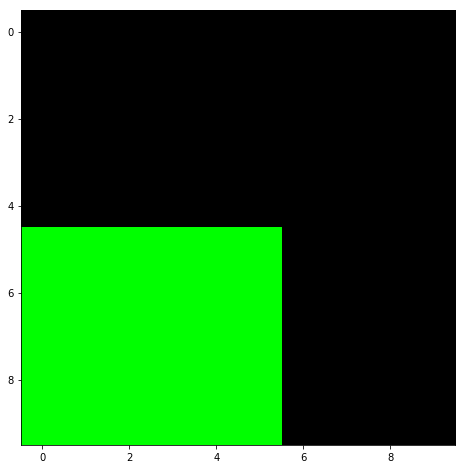

In [9]:
window = get_image_window(test_image, (511,0), 10)
plt.imshow(window, interpolation='none')

In [10]:
## parallel helpers
## Don't wrap them up in class
## since the function used in multiprocssing.Pool.apply_async must be picklable
## instance method is not picklable

def _par_get_gaussian_kernel(kernel_size):
    if kernel_size % 2 == 0:
        kernel_size += 1
    sigma = kernel_size / 5
    kernel_1D = cv2.getGaussianKernel(kernel_size, sigma)
    return kernel_1D.dot(kernel_1D.T)

def _par_padd_image(gray_image, win_width, pad_value=0):
    image_height, image_width = gray_image.shape
    pad_image_size = (image_height+win_width, image_width+win_width)
    win_size = (win_width, win_width)
    padded_image = np.zeros(pad_image_size, dtype=np.uint8)
    half_win_width = int(win_width/2)
    padded_image[half_win_width:half_win_width+image_height, half_win_width:half_win_width+image_width] = gray_image
    
    return padded_image

def _par_get_image_window(padded_image, center, win_width):
    center_x, center_y = center
    window = padded_image[center_y:center_y+win_width, center_x:center_x+win_width].copy()
    return window

def _par_get_sqi_pixel(gray_image, padded_image, center, kernel_size, transform = np.log10):
    x, y = center
    kernel_size = int(kernel_size)
    window = _par_get_image_window(padded_image, center, kernel_size)
    tou = window.mean()
    kernel = _par_get_gaussian_kernel(kernel_size)
    kernel[np.where(window < tou)] = 0
    kernel /= kernel.sum()
    return x, y, transform((gray_image[y,x]+1e-10)/((kernel*window).sum()+1e-10))

class SQImageGenerator(object):
    
    def __init__(self, kernel_sizes=None, weights=None):
        if kernel_sizes is None:
            kernel_sizes = [3, 9, 15]
        if weights is None:
            weights = [1 for _ in kernel_sizes ]
        assert len(weights) == len(kernel_sizes), \
          "number of weights is not equal to number of kernel sizes."
        self._kernel_sizes = list(map(float, kernel_sizes))
        self._weights = weights
    
    def getSQImage(self, image, transform=np.log10, verbose=False, par=False):
        if len(image.shape) > 2:
            gray_image = cv2.cvtColor(image[:,:,:3], cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image.copy()
        
        final_sqImage = np.zeros(gray_image.shape, dtype=np.float)
        for kernel_size, weight in zip(self._kernel_sizes, self._weights):
            if verbose:
                print("Processing kernel size {}, weight {}".format(kernel_size, weight))
            final_sqImage += weight*self._getSQImage(gray_image, 
                                                     kernel_size, 
                                                     transform=transform,
                                                     par=par)
        return self._normalize(final_sqImage)
        
    def _getSQImage(self, gray_image, kernel_size, transform=np.log10, par=False):
        sqimage = np.zeros(gray_image.shape)
        kernel_size = int(kernel_size)
        if par:
            pool= mp.Pool(mp.cpu_count())
            padded_image = _par_padd_image(gray_image, kernel_size)
            # (x,y) pairs
            pairs = product(range(gray_image.shape[1]), range(gray_image.shape[0]))
            results = [pool.apply_async(_par_get_sqi_pixel, (gray_image, padded_image, center, kernel_size,)) for center in pairs]
            pool.close()
            pool.join()
            for result in results:
                x, y, pixel = result.get()
                sqimage[y,x] = pixel
        else:
            for y in range(gray_image.shape[0]):
                for x in range(gray_image.shape[1]):
                    center = (x, y)
                    window = self._get_image_window(gray_image, center, kernel_size)
                    tou = window.mean()
                    kernel = self._get_gaussian_kernel(kernel_size)
                    kernel[np.where(window < tou)] = 0
                    kernel /= kernel.sum()
                    # add 1e-10 to prevent singularity
                    sqimage[y,x] = transform((gray_image[y,x]+1e-10)/((kernel*window).mean()+1e-10))
        return sqimage
        
    def _get_image_window(self, gray_image, center, win_width, pad_value=0):
        image_height, image_width = gray_image.shape
        pad_image_size = (image_height+win_width, image_width+win_width)
        win_size = (win_width, win_width)
        padded_image = np.zeros(pad_image_size, dtype=np.uint8)
        half_win_width = int(win_width/2)
        padded_image[half_win_width:half_win_width+image_height, half_win_width:half_win_width+image_width] = gray_image

        center_x, center_y = center
        window = padded_image[center_y:center_y+win_width, center_x:center_x+win_width].copy()
        return window
        
    def _get_gaussian_kernel(self, kernel_size):
        if kernel_size % 2 == 0:
            kernel_size += 1
        sigma = kernel_size / 5
        kernel_1D = cv2.getGaussianKernel(kernel_size, sigma)
        return kernel_1D.dot(kernel_1D.T)
    
    def _normalize(self, image):
        max_pv = image.max()
        min_pv = image.min()
        normed_image = (255*((image - min_pv)/(max_pv - min_pv))).astype(np.uint8)
        return normed_image

In [10]:
ori_image = cv2.imread("./James_Sa.jpg", cv2.IMREAD_COLOR)
ori_image.shape

(1280, 960, 3)

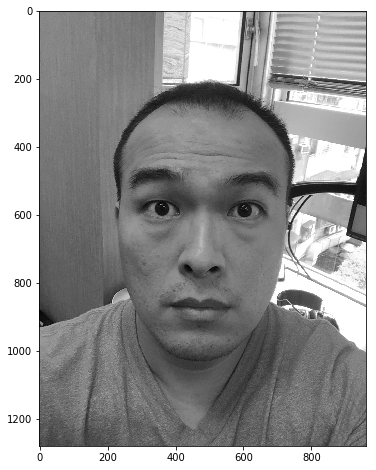

In [22]:
plt.imshow(ori_image.mean(axis=-1), cmap='gray', interpolation='none')

In [12]:
resized_image = cv2.resize(ori_image, (480, 640))

In [13]:
sqiGen = SQImageGenerator([3, 9, 15])

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 89.15516185760498


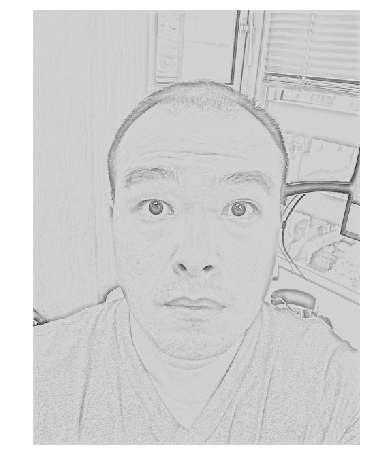

In [23]:
start_time = time.time()
sqImage_james = sqiGen.getSQImage(resized_image, verbose=True)
end_time = time.time()
print("duration: {}".format(end_time - start_time))
plt.axis('off')
plt.imshow(sqImage_james, cmap='gray', interpolation='none')

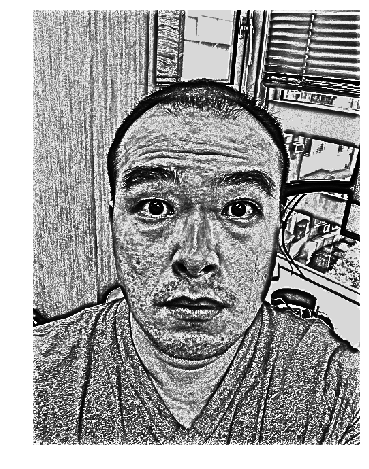

In [24]:
equ_sqImage_james = cv2.equalizeHist(sqImage_james)
plt.axis('off')
plt.imshow(equ_sqImage_james, cmap='gray', interpolation='none')

-----

## Test SQI

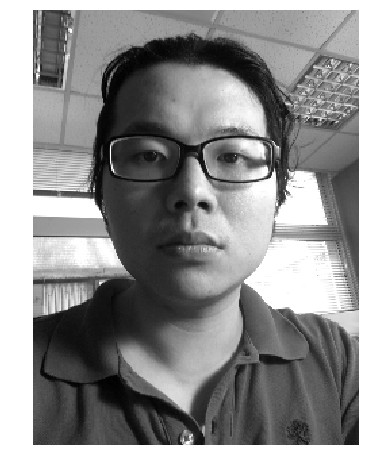

In [11]:
test_image = cv2.imread("./test_sqi.jpg", cv2.IMREAD_GRAYSCALE)
ori_height, ori_width = test_image.shape
test_image = cv2.resize(test_image, (int(ori_width/8), int(ori_height/8)))
plt.axis('off')
plt.imshow(test_image, cmap='gray', interpolation='none')

In [14]:
start_time = time.time()
test_sqimage_log10 = sqiGen.getSQImage(test_image, verbose=True)
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 14.806632995605469


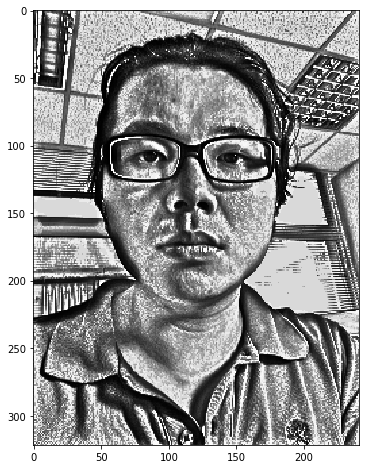

In [15]:
plt.imshow(cv2.equalizeHist(test_sqimage_log10), cmap='gray')

In [29]:
def sigmoid_gen(eta=1.0):
    def sigmoid(x):
        return 1/(1+np.exp(-eta*x))
    return sigmoid

In [30]:
start_time = time.time()
test_sqimage_sigmoid = sqiGen.getSQImage(test_image, verbose=True, transform=sigmoid_gen(0.7))
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 14.892882108688354


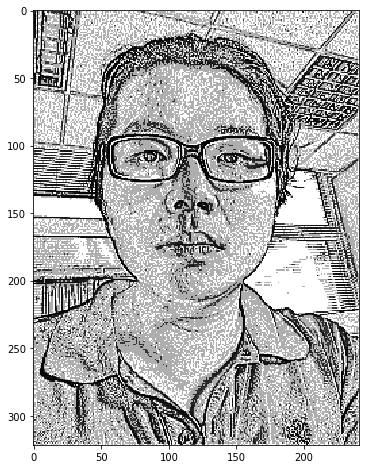

In [31]:
plt.imshow(cv2.equalizeHist(test_sqimage_sigmoid), cmap='gray')

In [32]:
start_time = time.time()
test_sqimage_arctan = sqiGen.getSQImage(test_image, verbose=True, transform=np.arctan)
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 15.536834955215454


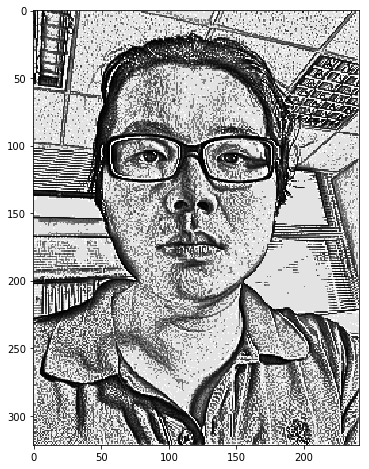

In [33]:
plt.imshow(cv2.equalizeHist(test_sqimage_arctan), cmap='gray')

In [34]:
bred_pitt_image = cv2.imread("./bred_pitt.jpg", cv2.IMREAD_GRAYSCALE)

In [35]:
bred_pitt_image.shape

(342, 340)

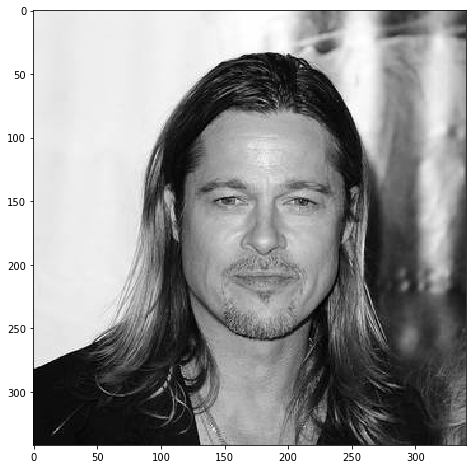

In [36]:
plt.imshow(bred_pitt_image, cmap='gray')

In [37]:
start_time = time.time()
pitt_sqimage_sigmoid = sqiGen.getSQImage(bred_pitt_image, verbose=True, transform=sigmoid_gen(0.7))
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 30.823601961135864


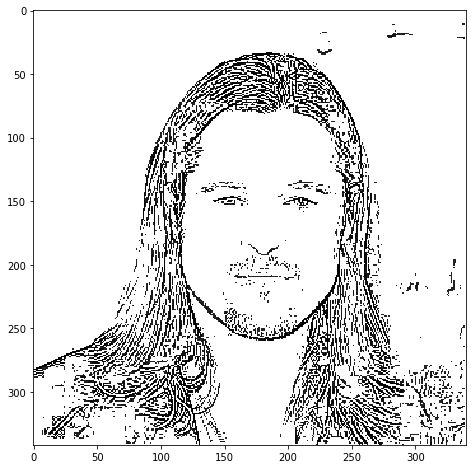

In [38]:
plt.imshow(cv2.equalizeHist(pitt_sqimage_sigmoid), cmap='gray')

In [39]:
chaplin_image = cv2.imread("./chaplin.jpg", cv2.IMREAD_GRAYSCALE)
chaplin_image.shape

(1238, 1024)

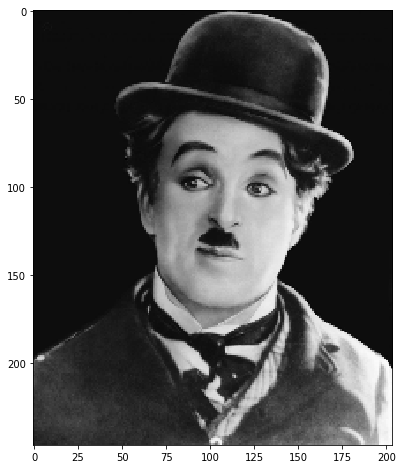

In [40]:
ori_height, ori_width = chaplin_image.shape
chaplin_image = cv2.resize(chaplin_image, (int(ori_width/5), int(ori_height/5)))
plt.imshow(chaplin_image, cmap='gray')

In [41]:
start_time = time.time()
chaplin_sqimage_sigmoid = sqiGen.getSQImage(chaplin_image, verbose=True, transform=sigmoid_gen(0.85))
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 9.934246063232422


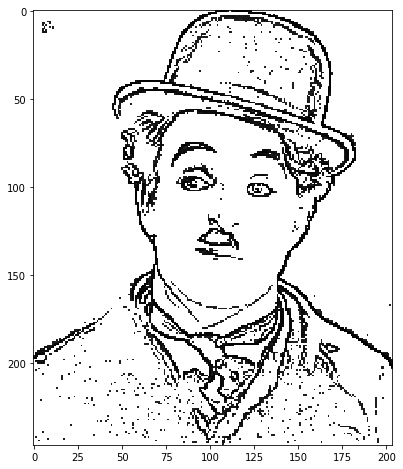

In [42]:
plt.imshow(cv2.equalizeHist(chaplin_sqimage_sigmoid), cmap='gray')

In [44]:
bred_pitt_paper_image = cv2.imread("./bred_pitt_paper.png", cv2.IMREAD_GRAYSCALE)
bred_pitt_paper_image.shape

(235, 203)

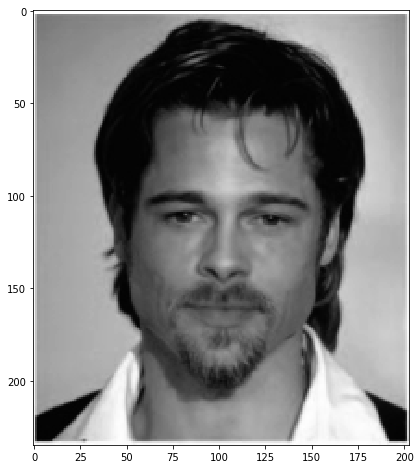

In [45]:
plt.imshow(bred_pitt_paper_image, cmap='gray')

In [46]:
start_time = time.time()
bred_pitt_paper_sqimage_sigmoid = sqiGen.getSQImage(bred_pitt_paper_image, verbose=True, transform=sigmoid_gen(0.85))
end_time = time.time()
print("duration: {}".format(end_time-start_time))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1
duration: 9.386727094650269


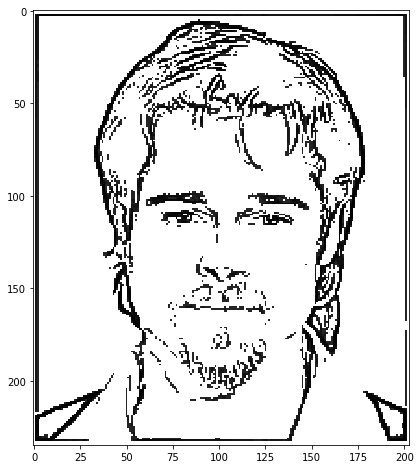

In [47]:
plt.imshow(cv2.equalizeHist(bred_pitt_paper_sqimage_sigmoid), cmap='gray')

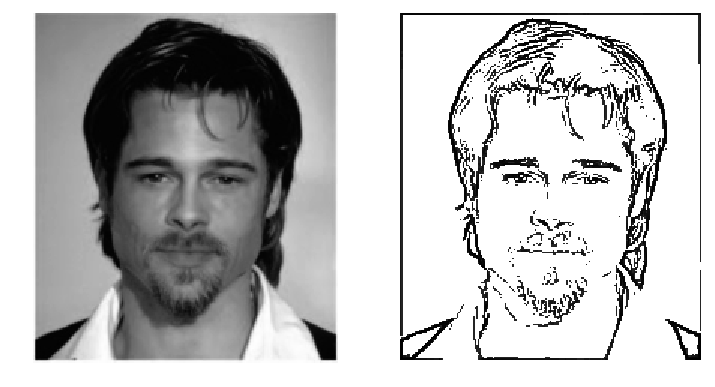

In [48]:
figure = plt.figure()
_ = figure.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(bred_pitt_paper_image, cmap='gray')
_ = figure.add_subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.equalizeHist(bred_pitt_paper_sqimage_sigmoid), cmap='gray')
# plt.savefig("./pitt_paprer_results.png", bbox_inches='tight')

----

## De-Shadowing

In [49]:
ori_image = cv2.bilateralFilter(cv2.imread("./bred_pitt_paper.png", cv2.IMREAD_COLOR), 3, 100, 100)

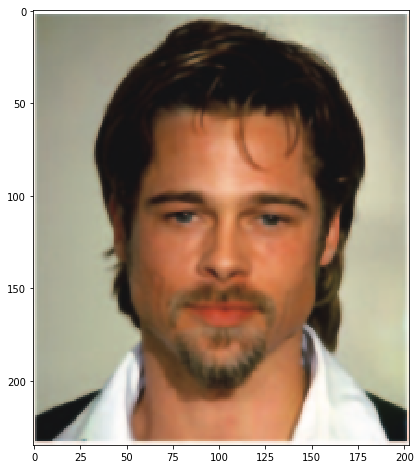

In [50]:
plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))

In [51]:
ori_image_hsv = cv2.cvtColor(ori_image, cv2.COLOR_BGR2HSV)

In [52]:
ori_image_h, ori_image_s, ori_image_v = ori_image_hsv[:,:,0], ori_image_hsv[:,:,1], ori_image_hsv[:,:,2]

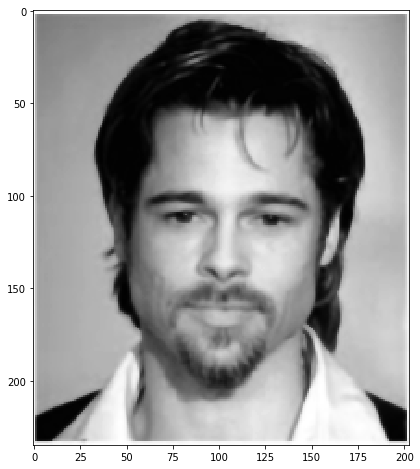

In [53]:
plt.imshow(ori_image_v, cmap='gray')

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


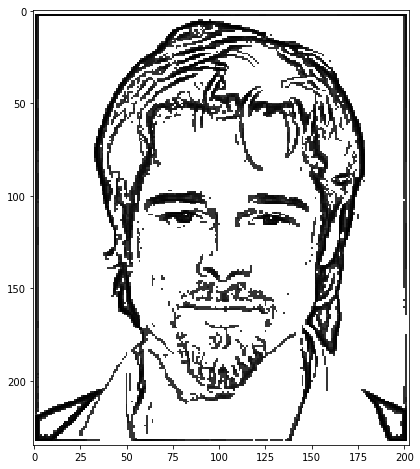

In [54]:
sqimage_v_sigmoid = cv2.equalizeHist(sqiGen.getSQImage(ori_image_v, verbose=True, transform=sigmoid_gen(0.75)))
plt.imshow(sqimage_v_sigmoid, cmap='gray')

In [55]:
new_image_hsv = np.zeros(ori_image.shape, dtype=np.uint8)

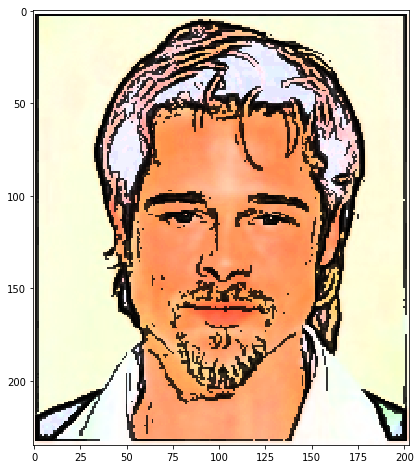

In [56]:
new_image_hsv[:,:,0], new_image_hsv[:,:,1], new_image_hsv[:,:,2] = ori_image_h, ori_image_s, sqimage_v_sigmoid
new_image = cv2.cvtColor(new_image_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(new_image)

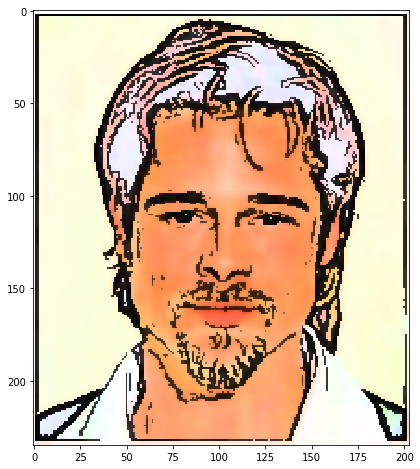

In [57]:
plt.imshow(cv2.bilateralFilter(new_image, 5, 200, 200))

In [59]:
captain_image = cv2.imread("./data/beard_faces/captain_american.jpg", cv2.IMREAD_COLOR)
captain_image.shape

(2221, 1498, 3)

In [60]:
captain_image = cv2.resize(captain_image, (375, 555))
captain_image_hsv = cv2.cvtColor(captain_image, cv2.COLOR_BGR2HSV)
captain_image_h, captain_image_s, captain_image_v = captain_image_hsv[:,:,0], captain_image_hsv[:,:,1], captain_image_hsv[:,:,2]

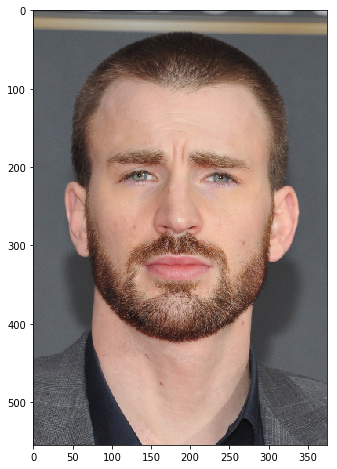

In [61]:
plt.imshow(cv2.cvtColor(captain_image, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


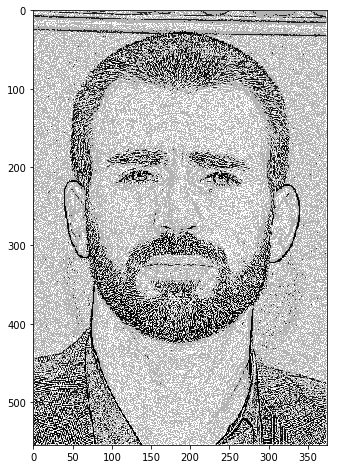

In [62]:
sqimage_captain_sigmoid = cv2.equalizeHist(sqiGen.getSQImage(captain_image_v, verbose=True, transform=sigmoid_gen(0.8)))
plt.imshow(sqimage_captain_sigmoid, cmap='gray', interpolation='none')

In [63]:
new_captain_hsv = np.zeros(captain_image.shape, dtype=np.uint8)
new_captain_hsv[:,:,0], new_captain_hsv[:,:,1], new_captain_hsv[:,:,2] = captain_image_h, captain_image_s, sqimage_captain_sigmoid

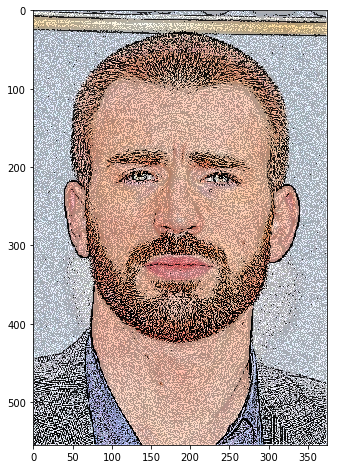

In [64]:
new_captain = cv2.cvtColor(new_captain_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(new_captain)

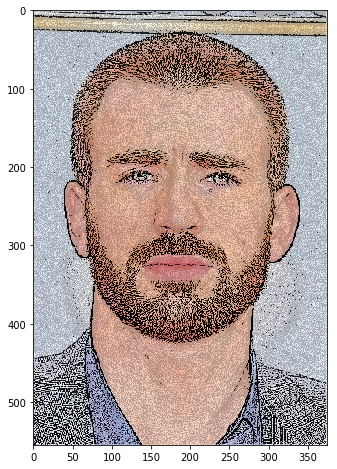

In [65]:
plt.imshow(cv2.bilateralFilter(new_captain, 10, 100, 100))

In [66]:
sqimage_captain_log10 = cv2.equalizeHist(sqiGen.getSQImage(captain_image_v, verbose=True))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


In [67]:
new_captain_hsv = np.zeros(captain_image.shape, dtype=np.uint8)
new_captain_hsv[:,:,0], new_captain_hsv[:,:,1], new_captain_hsv[:,:,2] = captain_image_h, captain_image_s, sqimage_captain_log10

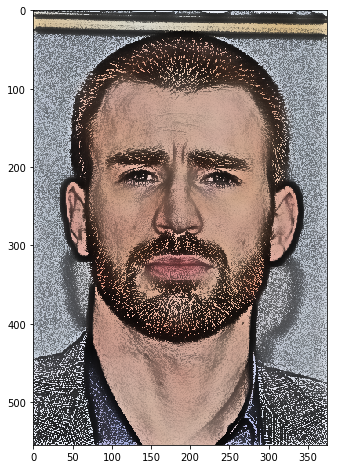

In [68]:
new_captain = cv2.cvtColor(new_captain_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(cv2.bilateralFilter(new_captain, 20, 150, 150))

In [69]:
def deShadow(image, verbose=False, transform=np.log10):
    if len(image.shape) < 3:
        color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        color_image = image[:,:,:3]
    sqiGen = SQImageGenerator()
    image_hsv = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
    image_v = image_hsv[:,:,2]
    sqimage_v = sqiGen.getSQImage(image_v, verbose=verbose, transform=transform)
    sqimage_v = cv2.equalizeHist(sqimage_v)
    sqimage_v = cv2.bilateralFilter(sqimage_v, 10, 200, 200)
    mean_v, std_v = sqimage_v.mean(), sqimage_v.std()
    sqimage_v[np.where(sqimage_v < mean_v - 2*std_v)] = 0
    
    new_image_hsv = np.zeros(color_image.shape, dtype=np.uint8)
    new_image_hsv[:,:,:2] = image_hsv[:,:,:2]
    new_image_hsv[:,:,2] = sqimage_v
    new_image = cv2.cvtColor(new_image_hsv, cv2.COLOR_HSV2BGR)
    
    return new_image

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


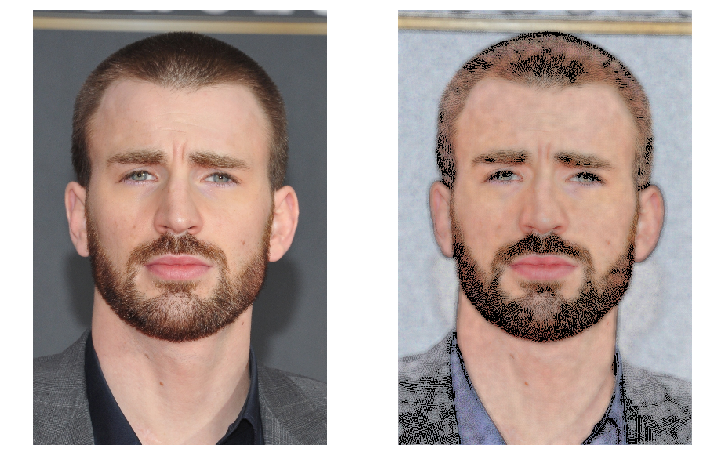

In [70]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(captain_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(captain_image, True, sigmoid_gen(0.8))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


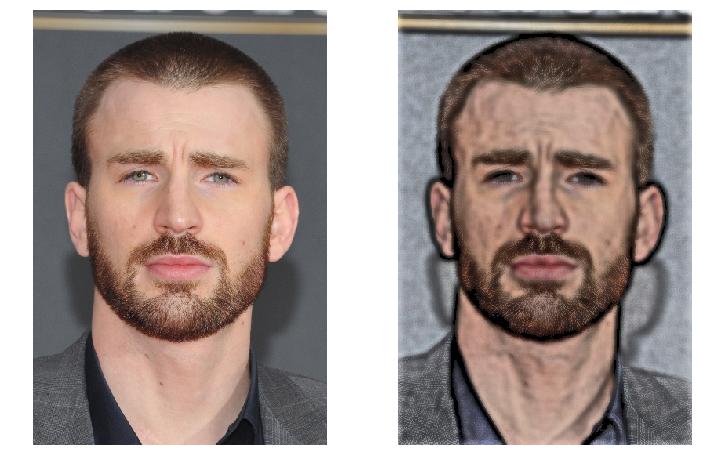

In [71]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(captain_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_log10 = deShadow(captain_image, True)
plt.imshow(cv2.cvtColor(image_deshadow_log10, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


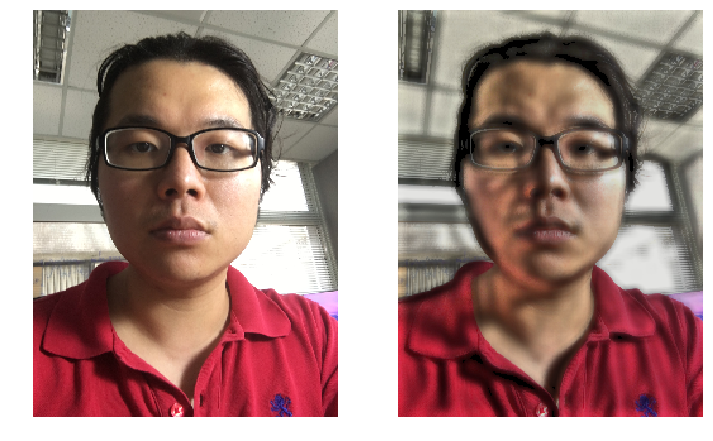

In [72]:
test_image = cv2.imread("./test_sqi.jpg", cv2.IMREAD_COLOR)
ori_height, ori_width = test_image.shape[:2]
test_image = cv2.resize(test_image, (int(ori_width/8), int(ori_height/8)))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_log10 = deShadow(test_image, True)
plt.imshow(cv2.cvtColor(image_deshadow_log10, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


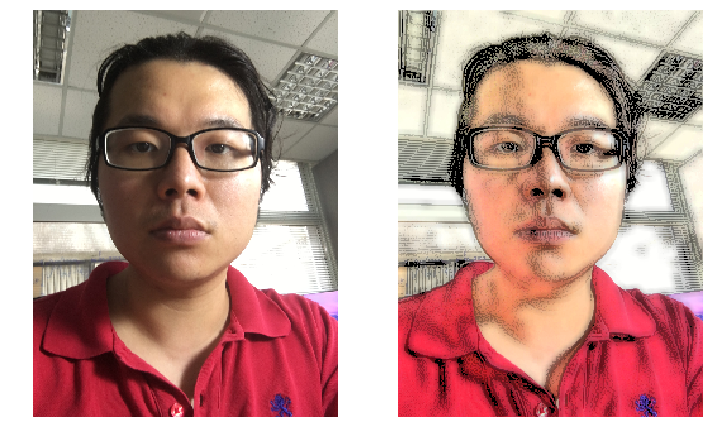

In [73]:
test_image = cv2.imread("./test_sqi.jpg", cv2.IMREAD_COLOR)
ori_height, ori_width = test_image.shape[:2]
test_image = cv2.resize(test_image, (int(ori_width/8), int(ori_height/8)))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.75))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


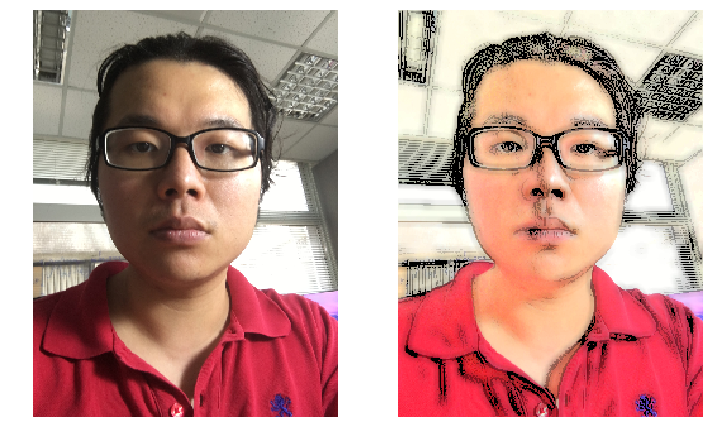

In [74]:
test_image = cv2.imread("./test_sqi.jpg", cv2.IMREAD_COLOR)
ori_height, ori_width = test_image.shape[:2]
test_image = cv2.resize(test_image, (int(ori_width/8), int(ori_height/8)))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.8))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


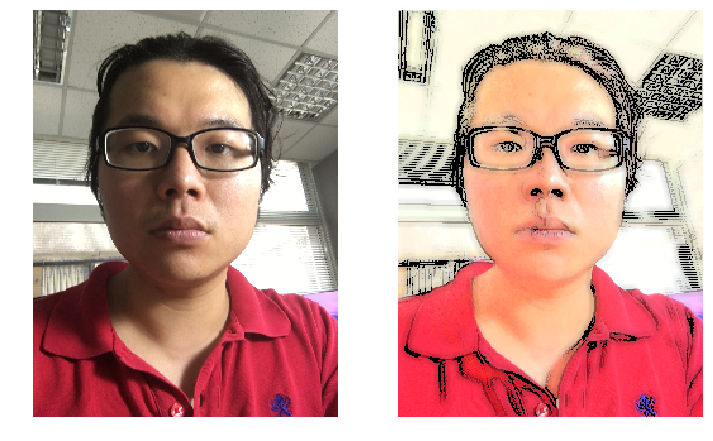

In [75]:
test_image = cv2.imread("./test_sqi.jpg", cv2.IMREAD_COLOR)
ori_height, ori_width = test_image.shape[:2]
test_image = cv2.resize(test_image, (int(ori_width/8), int(ori_height/8)))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.85))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


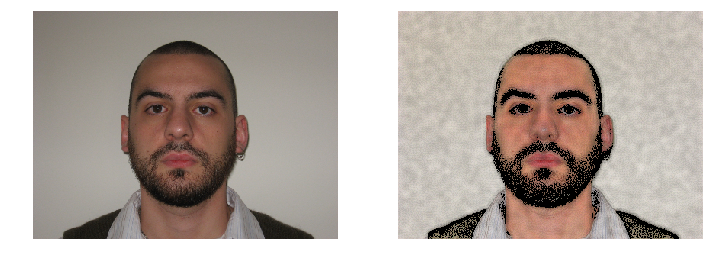

In [76]:
test_image = cv2.imread("./data/beard_faces/playoff-beard-front-week-2.jpg", cv2.IMREAD_COLOR)
test_image = cv2.resize(test_image, (400, 300))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.75))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


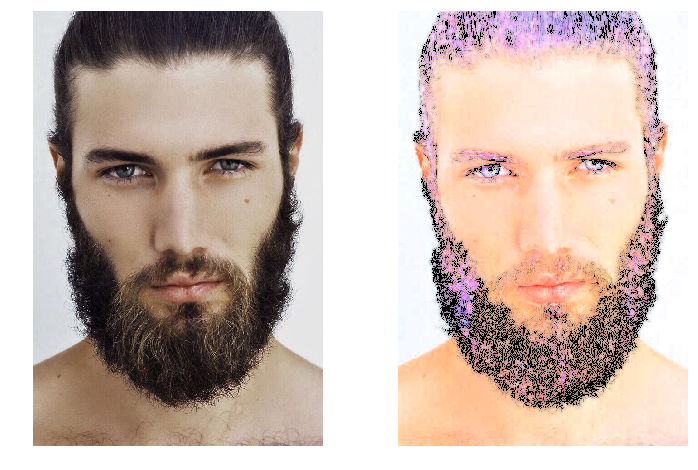

In [77]:
test_image = cv2.imread("./data/beard_faces/0192b31bb7249f2f48c213edcfda4a7e.jpg", cv2.IMREAD_COLOR)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.75))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


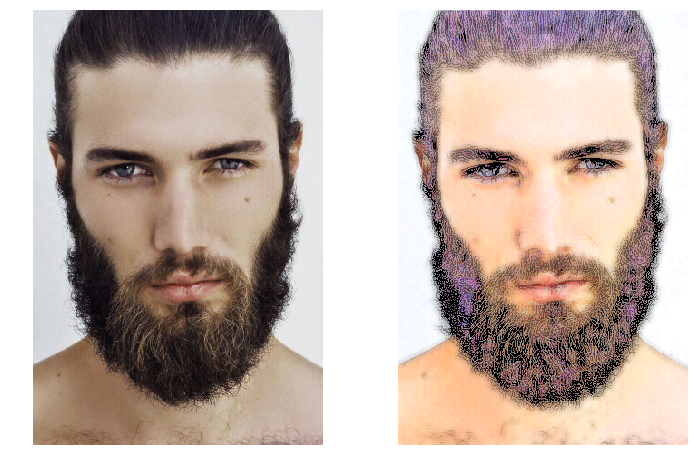

In [78]:
test_image = cv2.imread("./data/beard_faces/0192b31bb7249f2f48c213edcfda4a7e.jpg", cv2.IMREAD_COLOR)
test_image = cv2.resize(test_image, (320, 480))

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.8))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

Processing kernel size 3.0, weight 1
Processing kernel size 9.0, weight 1
Processing kernel size 15.0, weight 1


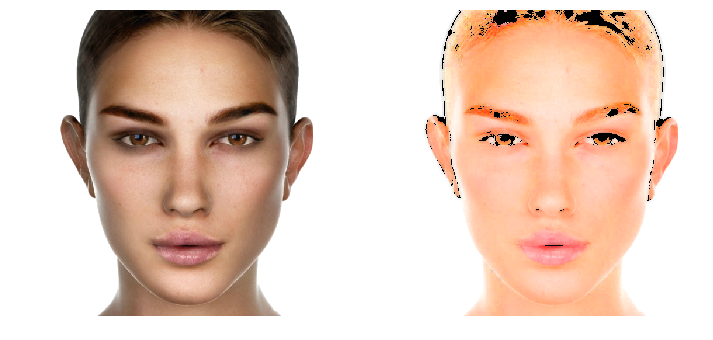

In [79]:
test_image = cv2.imread("./data/clean_faces/face_PNG5647.png", cv2.IMREAD_COLOR)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.axis('off')
image_deshadow_sigmoid = deShadow(test_image, True, sigmoid_gen(0.75))
plt.imshow(cv2.cvtColor(image_deshadow_sigmoid, cv2.COLOR_BGR2RGB))

## References

- [Face Recognition under Varying Lighting Conditions Using Self Quotient Image](http://www.cbsr.ia.ac.cn/publications/Stan/WHT-FG2004.pdf)
  - Section 3.2 Implementation of SQI 
- [Bob - Python Package for Image Processing](https://pythonhosted.org/bob/index.html)
  - [bob.bio.face](https://pythonhosted.org/bob.bio.face/index.html)
- [libface - sqi](http://libface.sourceforge.net/libface-0.1-html/d8/d4c/sqi_8cpp-source.html)
- Papers
  - [BEARD AND MUSTACHE SEGMENTATION USING SPARSE CLASSIFIERS ON SELF-QUOTIENT IMAGES](papers/ICIP_2012_Paper_2_IEEE.pdf)
  - [Self Quotient Image for Face Recognition](papers/afb134f0aad4075bfb55ce970e857da8075c.pdf)
  - [Face Recognition under Varying Lighting Conditions Using Self Quotient Image](papers/WHT-FG2004.pdf)
  
- [OpenCV - Range Selection](http://answers.opencv.org/question/79889/copy-small-part-of-mat-to-another/)